In [1]:
%load_ext jupyter_black

In [2]:
from __future__ import annotations

import os

import numpy as np
import mesoscaler as ms

In [3]:
_mount_path = "/mnt/data/"

urma_store = os.path.join(_mount_path, "urma2p5.zarr")
assert os.path.exists(urma_store)
era5_store = os.path.join(_mount_path, "era5", "2019-2022-upper-air-1h-0p25deg.zarr")
assert os.path.exists(era5_store)

In [4]:
dataset_sequence = ms.open_datasets([(urma_store, [ms.URMA.T2M, ms.URMA.D2M]), (era5_store, [ms.ERA5.T, ms.ERA5.Q])])
dataset_sequence

DatasetSequence(size=2)[
<xarray.DependentDataset>
Dimensions:                  (T: 7128, Z: 1, Y: 1597, X: 2345)
Coordinates:
    latitude                 (Y, X) float64 19.23 19.23 19.24 ... 54.38 54.37
    longitude                (Y, X) float64 233.7 233.7 233.8 ... 300.9 301.0
  * time                     (T) datetime64[ns] 2019-01-02 ... 2019-10-27T23:...
  * vertical                 (Z) float64 1.013e+03
Dimensions without coordinates: T, Z, Y, X
Data variables:
    dewpoint_temperature_2m  (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    temperature_2m           (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
Attributes:
    depends:  Dependencies(URMA)
<xarray.DependentDataset>
Dimensions:            (Y: 721, X: 1440, Z: 23, T: 26304)
Coordinates:
    latitude           (Y, X) float32 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * vertical           (Z) int64 200 225 250 300 350 ... 900 925 950 975 1000
    longitude          (Y, X) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time               (T) datetime64[ns] 2019-01-01 ... 2021-12-31T23:00:00
Dimensions without coordinates: Y, X, Z, T
Data variables:
    specific_humidity  (T, Z, Y, X) float32 dask.array<chunksize=(1, 23, 721, 1440), meta=np.ndarray>
    temperature        (T, Z, Y, X) float32 dask.array<chunksize=(1, 23, 721, 1440), meta=np.ndarray>
Attributes:
    depends:  Dependencies(ERA5)
]

Mesoscale(size=6):
-       scale: [ 1.00  3.81  9.43 11.69 13.52 14.78]
- levels[hPa]: [1013.25 1000.00  850.00  700.00  500.00  300.00]
-  extent[km]: 
[[ -200.00  -150.00   200.00   150.00]
 [ -761.70  -571.28   761.70   571.28]
 [-1885.10 -1413.83  1885.10  1413.83]
 [-2338.60 -1753.95  2338.60  1753.95]
 [-2704.87 -2028.65  2704.87  2028.65]
 [-2956.21 -2217.15  2956.21  2217.15]]


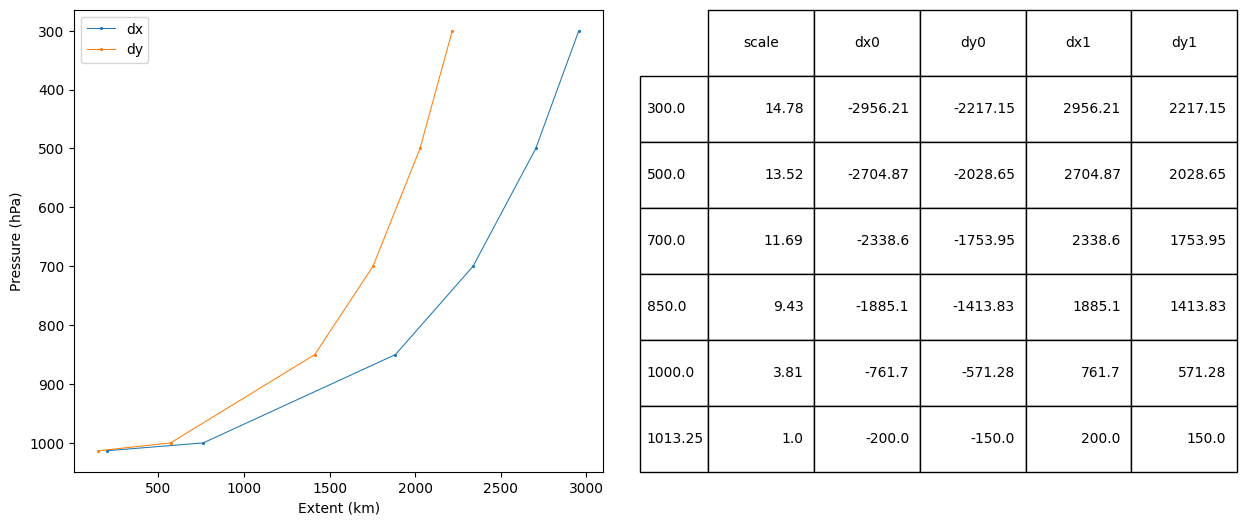

In [5]:
scale = ms.Mesoscale(200, 150, levels=[1013.25, 1000.0, 850, 700, 500, 300], xy_units="km")
scale.plot.table()
print(scale)

Fitting the dataset to the scale will remove any data where the time dimension does not overlap and fit the levels to the scale

In [6]:
dsets = dataset_sequence.fit(scale)

urma, era5 = dsets
assert np.all(urma.time == era5.time).item()
assert np.all(np.sort(np.concatenate([urma.level, era5.level])) == np.sort(scale.levels))

In [7]:
resampler = scale.resample(dsets, height=60, width=80)
resampler

In [8]:
longitude = -89.85
latitude = 38.55
batched_time = resampler.batch_time(4)
print(batched_time)
time_sample = batched_time[0]
sample = resampler.__call__(longitude, latitude, time_sample)
sample.shape

[['2019-01-02T00:00:00.000000000' '2019-01-02T01:00:00.000000000'
  '2019-01-02T02:00:00.000000000' '2019-01-02T03:00:00.000000000']
 ['2019-01-02T04:00:00.000000000' '2019-01-02T05:00:00.000000000'
  '2019-01-02T06:00:00.000000000' '2019-01-02T07:00:00.000000000']
 ['2019-01-02T08:00:00.000000000' '2019-01-02T09:00:00.000000000'
  '2019-01-02T10:00:00.000000000' '2019-01-02T11:00:00.000000000']
 ...
 ['2019-10-27T12:00:00.000000000' '2019-10-27T13:00:00.000000000'
  '2019-10-27T14:00:00.000000000' '2019-10-27T15:00:00.000000000']
 ['2019-10-27T16:00:00.000000000' '2019-10-27T17:00:00.000000000'
  '2019-10-27T18:00:00.000000000' '2019-10-27T19:00:00.000000000']
 ['2019-10-27T20:00:00.000000000' '2019-10-27T21:00:00.000000000'
  '2019-10-27T22:00:00.000000000' '2019-10-27T23:00:00.000000000']]


(2, 4, 6, 60, 80)

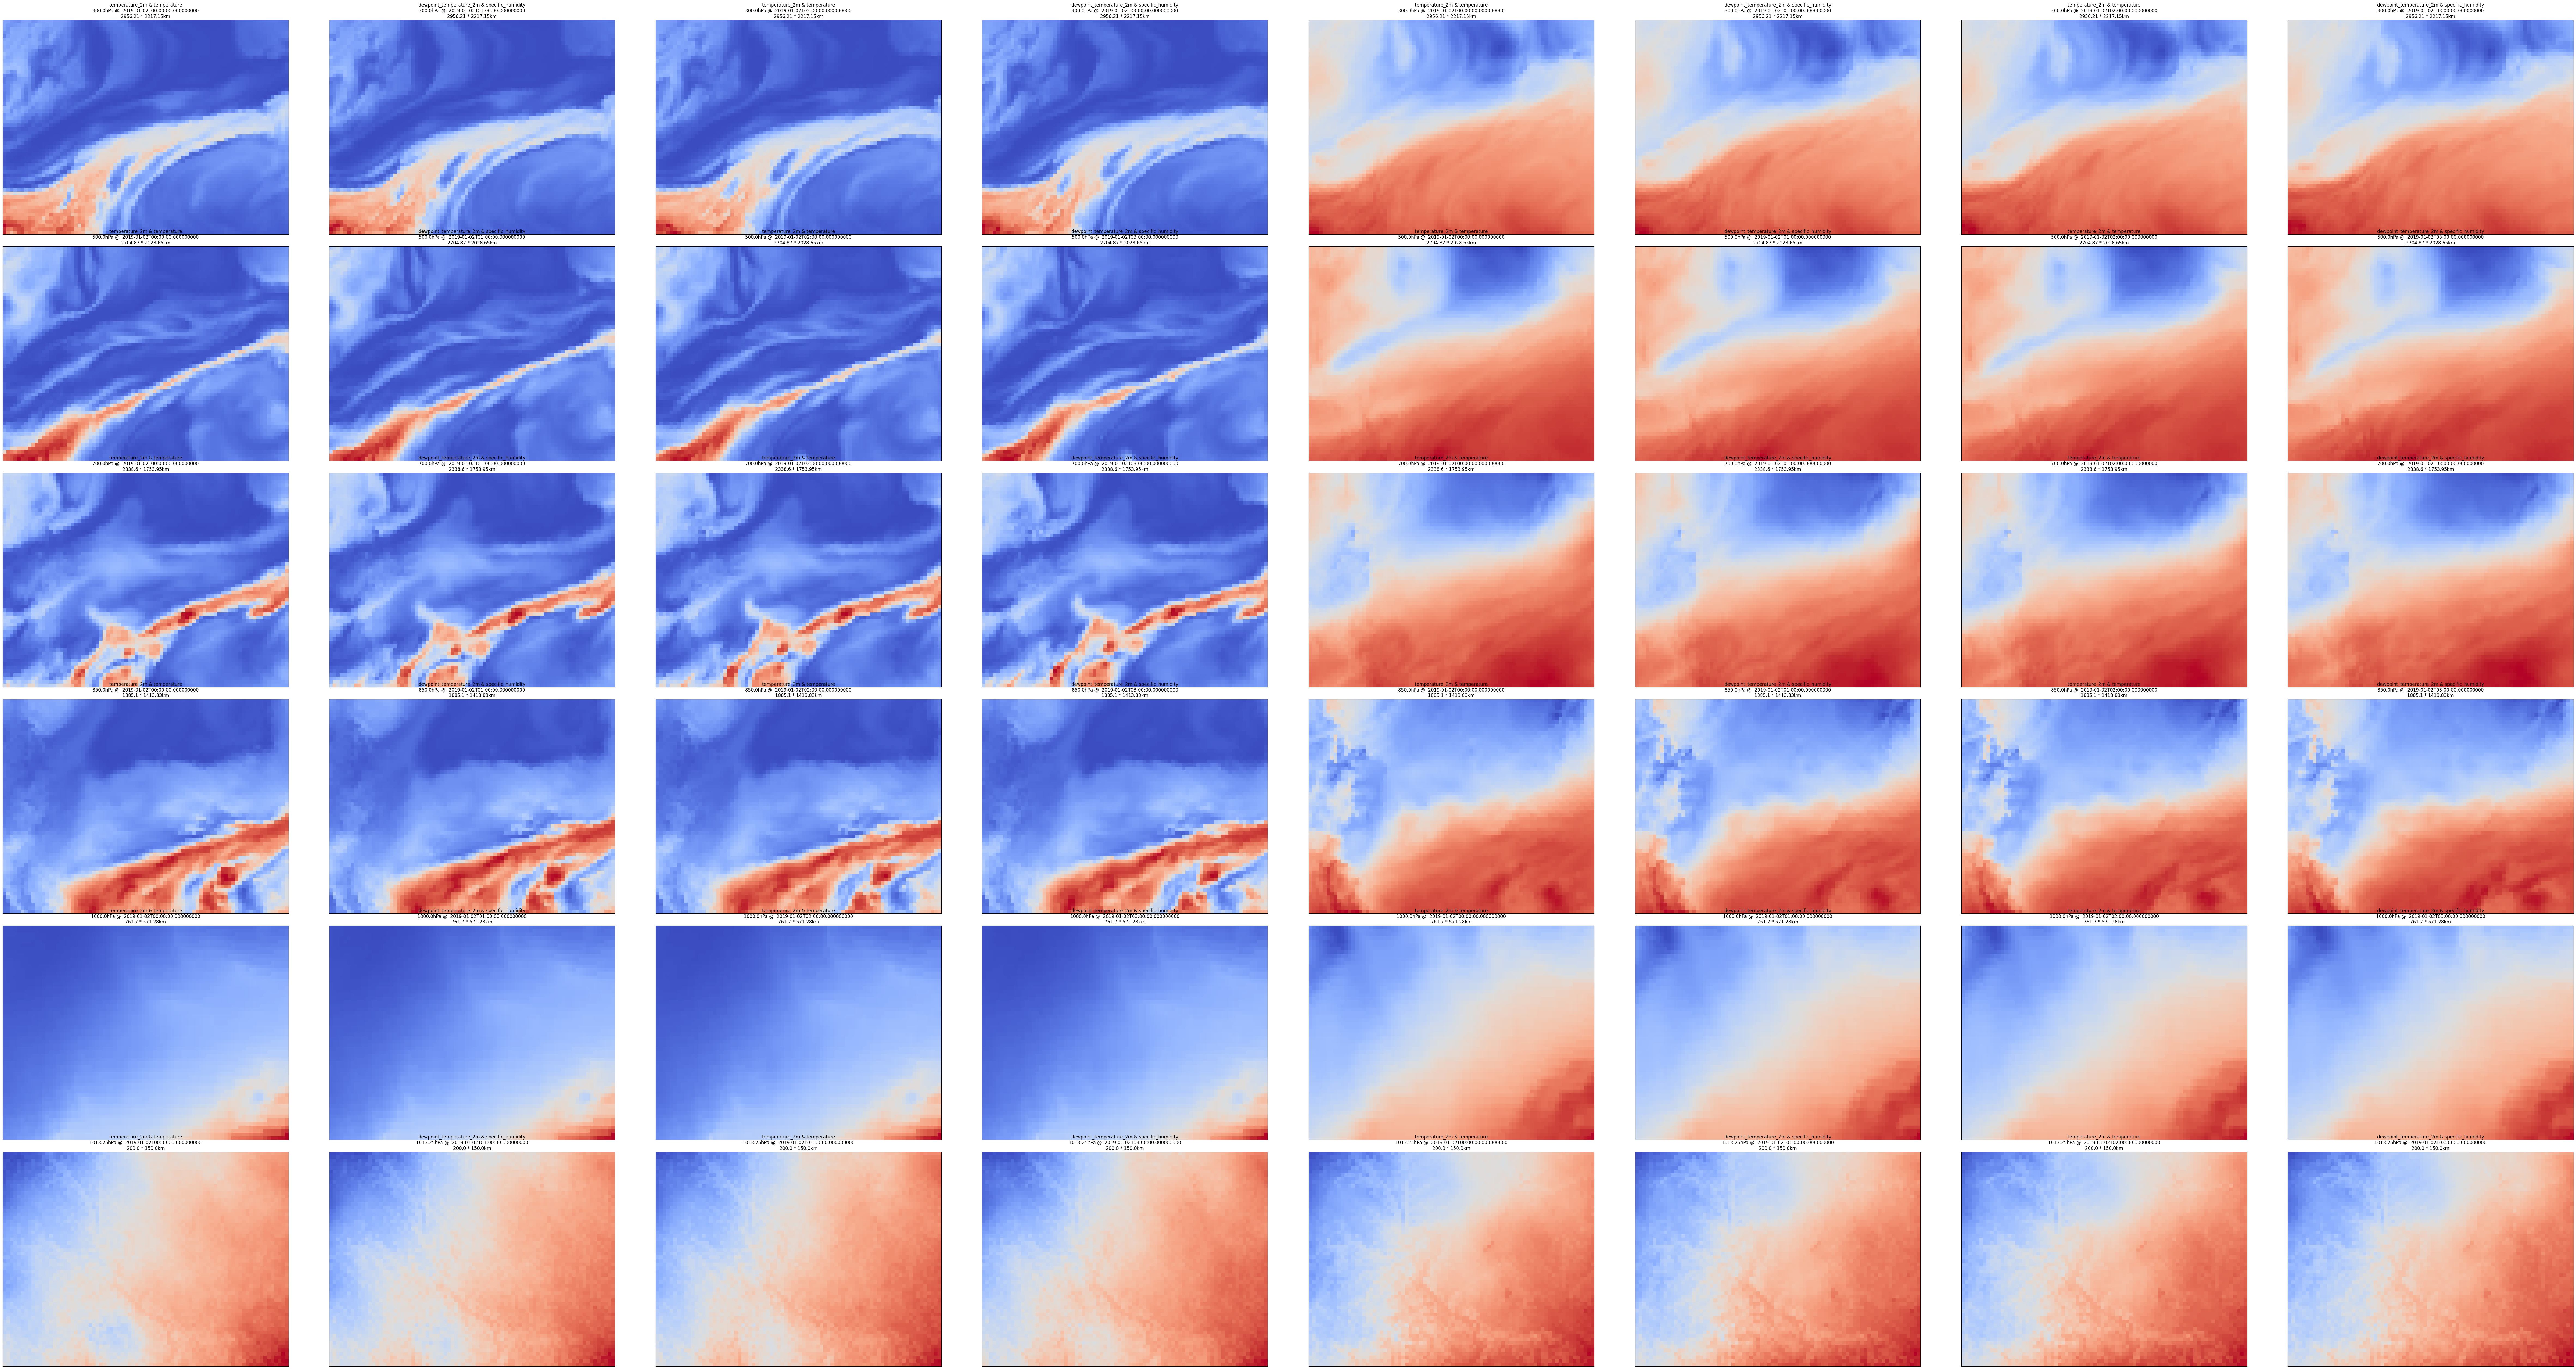

In [9]:
import matplotlib.pyplot as plt

V, T, Z, Y, X = sample.shape
fig, axes = plt.subplots(Z, T * V, figsize=(24 * T, 50))
fig.tight_layout()
axes = axes[::-1]


vrbs = [[f"{ms.URMA.T2M} & {ms.ERA5.T}", f"{ms.URMA.D2M} & {ms.ERA5.Q}"] * V] * T

for vx in range(V):
    for tx in range(T):
        name = vrbs[vx][tx]
        for zx in range(Z):
            extent = resampler.area_extents[zx]
            ax = axes[zx, vx * T + tx]
            assert isinstance(ax, plt.Axes)
            dx, dy = (extent[-2:] / 1000).round(2)
            ax.set_title(f"{name}\n{scale.levels[zx]}hPa @  {time_sample[tx]}\n{dx} * {dy}km")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(sample[vx, tx, zx], cmap="coolwarm")

In [10]:
levels = [1013.25, 1000.0, 850, 700, 600, 500, 400, 300]
texas = -106.6, 25.8, -93.5, 36.5
producer = ms.create.producer(
    dataset_sequence,
    ms.AreaOfInterestSampler.partial(aoi=texas, time_step=1),
    dx=200,
    dy=200 * 0.75,
    width=80,
    height=int(80 * 0.75),
    levels=[1013.25, 1000.0, 850, 700, 600, 500, 400, 300],
)
producer

TypeError: AreaOfInterestSampler.__init__() got an unexpected keyword argument 'time_step'

In [ ]:
idx = producer.indices[0]

print(idx)
sample = producer[idx]

sample.shape

In [ ]:
producer.scale.plot.table()

In [ ]:
from mesoscaler._typing import Array, Nv, Nt, Nz, Nx, Ny


V, T, Z, Y, X = sample.shape
vrbs = [[f"{ms.URMA.T2M} & {ms.ERA5.T}", f"{ms.URMA.D2M} & {ms.ERA5.Q}"] * V] * T
fig, axes = plt.subplots(Z, (V * T), figsize=(2 * Z, 25 * (V * T)))
fig.tight_layout()
axes = axes[::-1]
scale = producer.scale


for vx in range(V):
    for tx in range(T):
        for zx in range(Z):
            ax = axes[zx, tx * V + vx]
            assert isinstance(ax, plt.Axes)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(sample[vx, tx, zx], cmap="coolwarm")
            dx, dy = scale.area_extent[zx][-2:].round(2)
            name = vrbs[tx][vx]
            ax.set_title(f"{name}\n{scale.levels[zx]}hPa @  {dx} * {dy}km")

# batch[0:1, 0:1].shape
# batch
# plot_sample(batch)